In [1]:
%matplotlib notebook
import atomap.api as am
import hyperspy.api as hs

In [2]:
s = hs.load('9Frame Grabber 60 frames.dm3') 

<IPython.core.display.Javascript object>


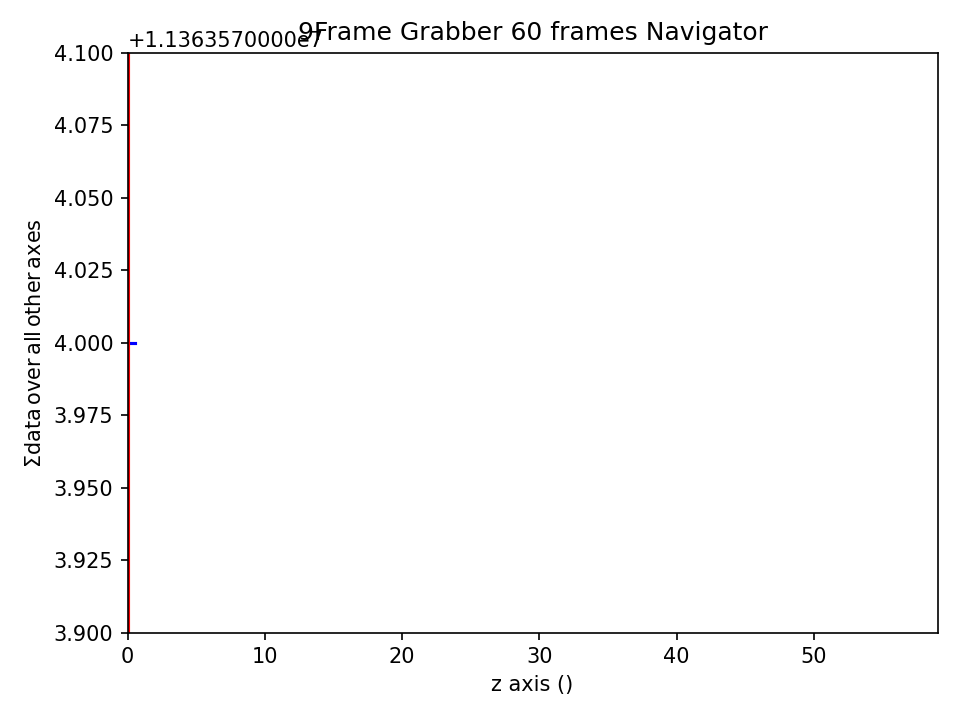

<IPython.core.display.Javascript object>


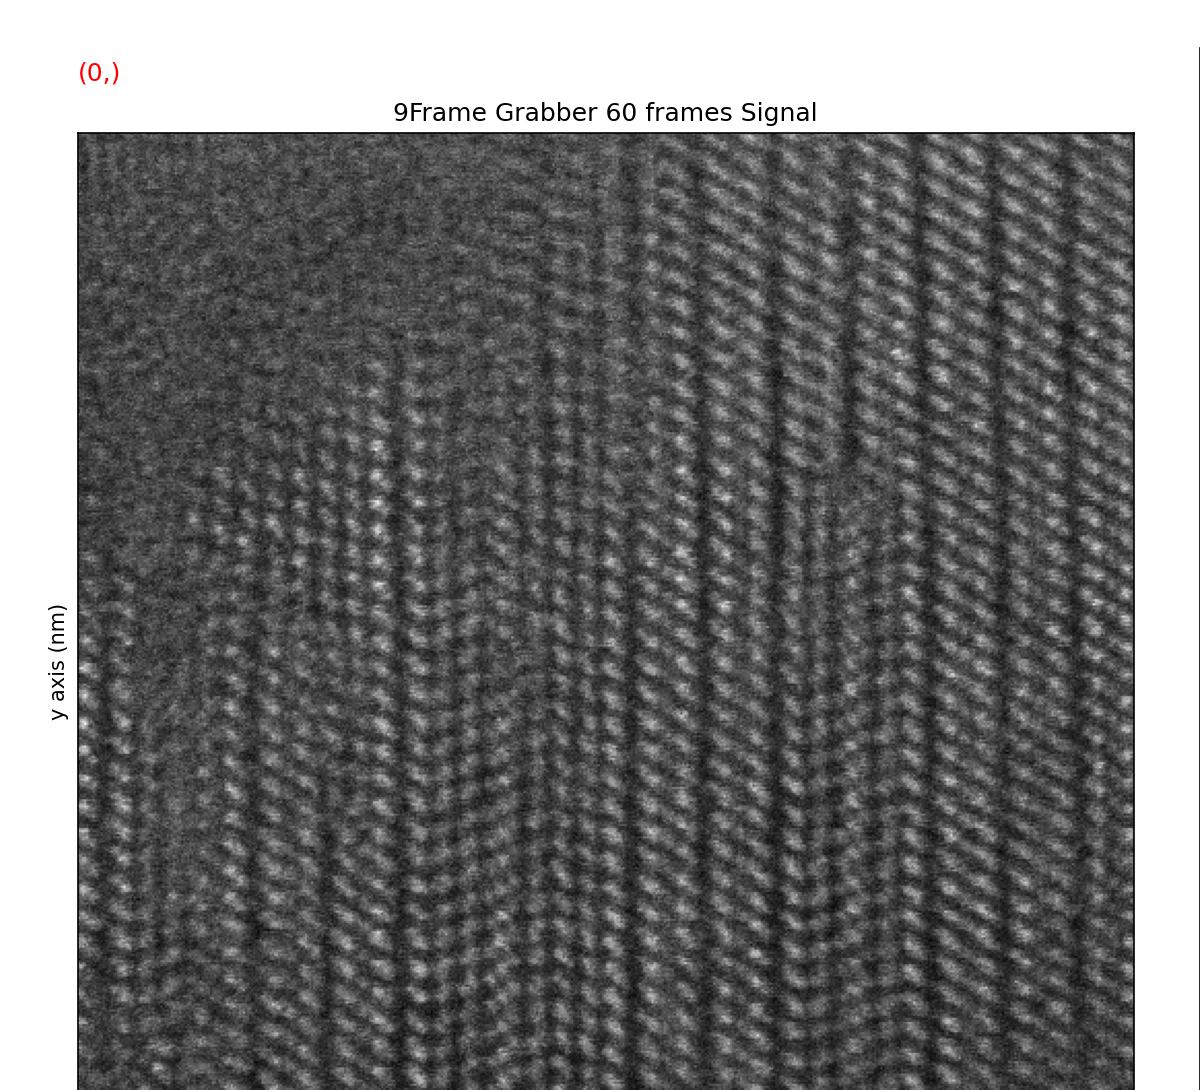

<Axes manager, axes: (60|512, 512)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               z |     60 |      0 |      -0 |       1 |        
---------------- | ------ | ------ | ------- | ------- | ------ 
               x |    512 |      0 |      -0 |   0.026 |     nm 
               y |    512 |      0 |      -0 |   0.026 |     nm

In [3]:
s.plot()
s.axes_manager #pixel size = 0.02622468769550323nm

In [4]:
shifts = s.estimate_shift2D(sub_pixel_factor=26)  #about 1 picometer accuracy

  0%|          | 0/60 [00:00<?, ?it/s]

[########################################] | 100% Completed |  0.7s


<IPython.core.display.Javascript object>


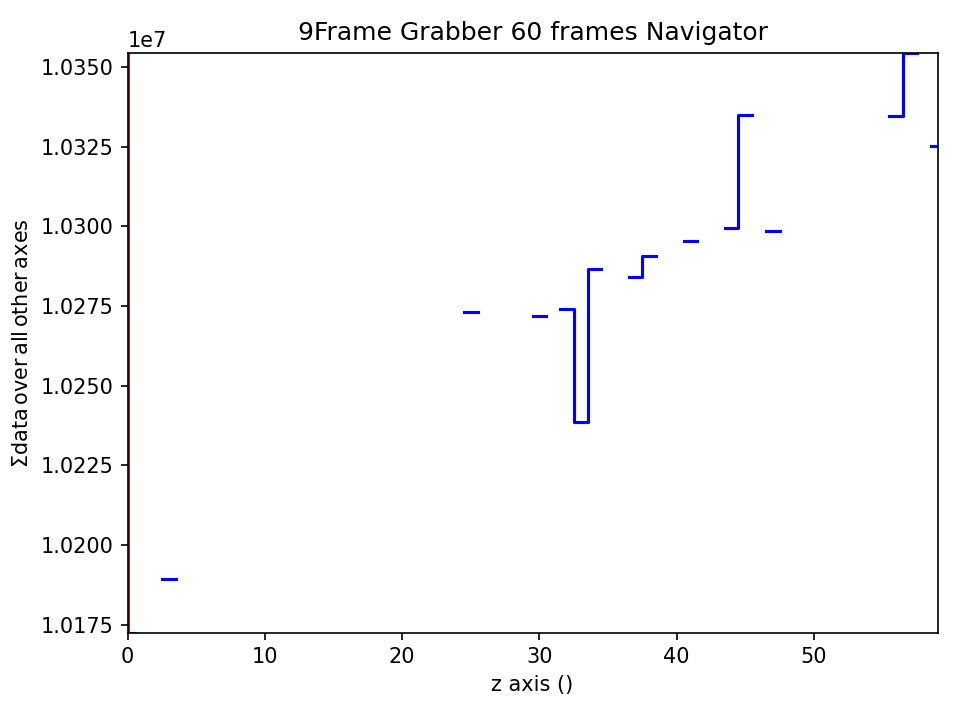

<IPython.core.display.Javascript object>


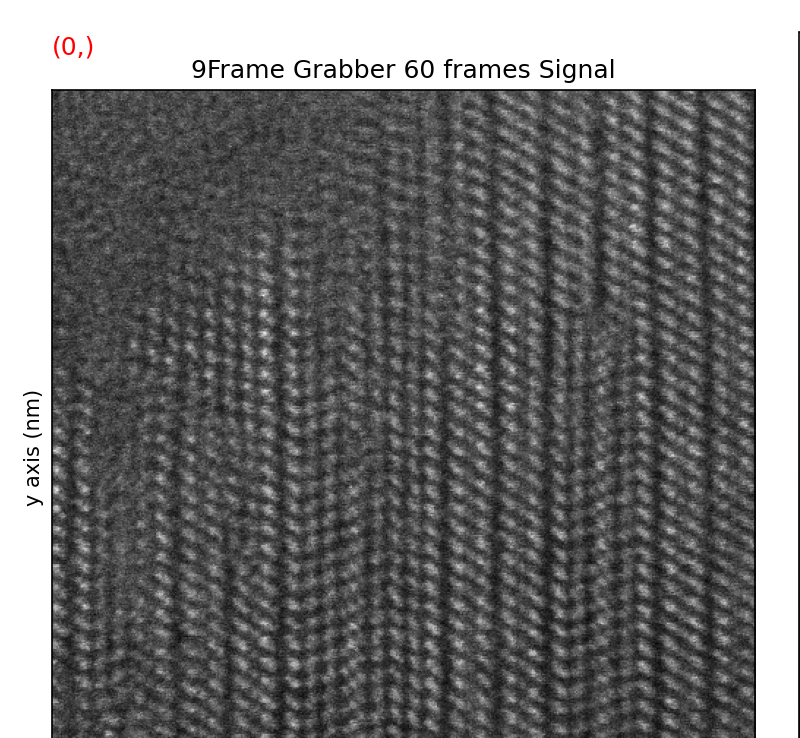

In [5]:
s_copy = s.copy()
s_copy.align2D(shifts=shifts)
s_copy.plot()

  0%|          | 0/60 [00:00<?, ?it/s]

[########################################] | 100% Completed |  0.5s


<IPython.core.display.Javascript object>


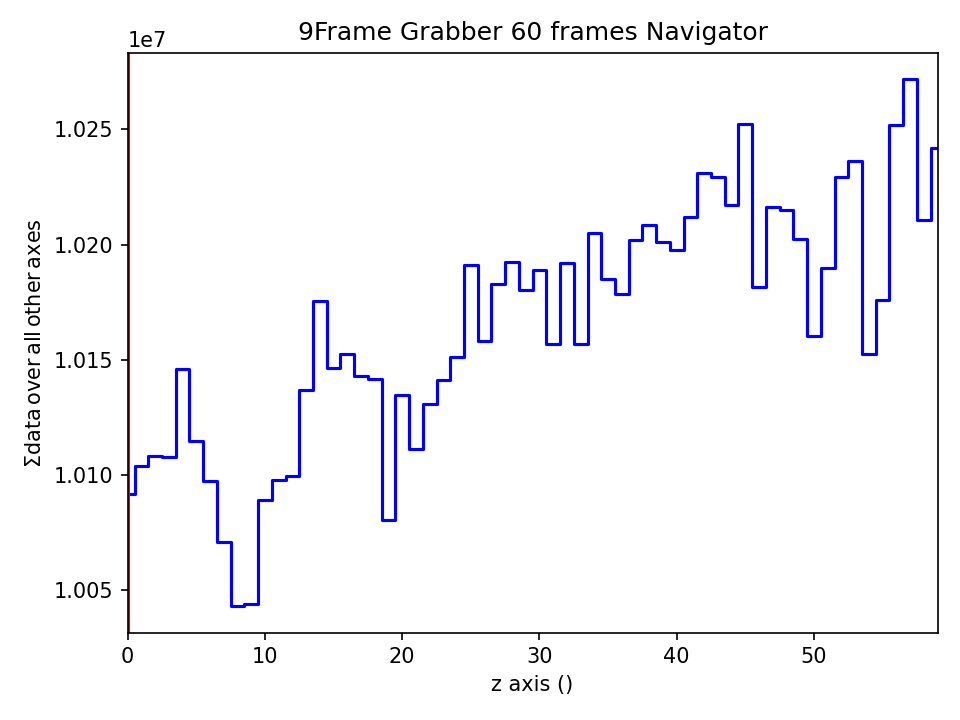

<IPython.core.display.Javascript object>


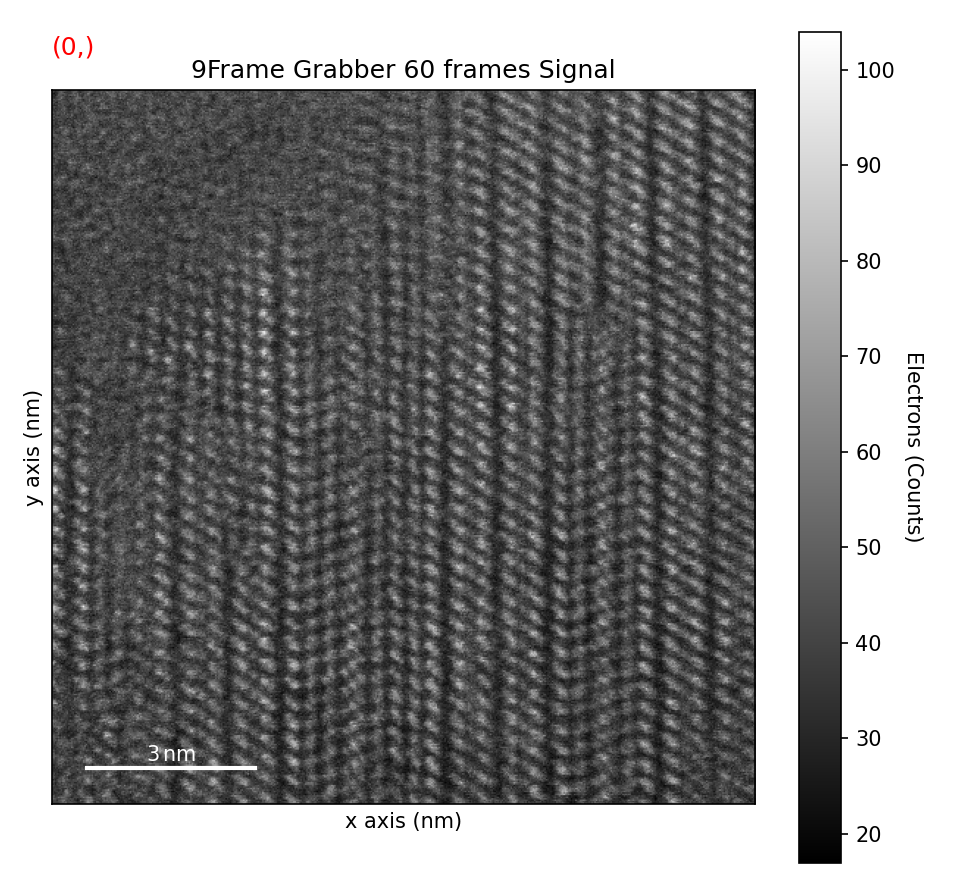

In [7]:
shifts = s_copy.estimate_shift2D(sub_pixel_factor=26)
s_copy = s_copy.copy()
s_copy.align2D(shifts=shifts)
s_copy.plot()

In [8]:
s_copy.save('9_registered_1pm.tiff')

Overwrite 'D:\Users\Mengkun Tian\Athena\240319_In2Se3\9_registered_1pm.tiff' (y/n)?
y


<IPython.core.display.Javascript object>


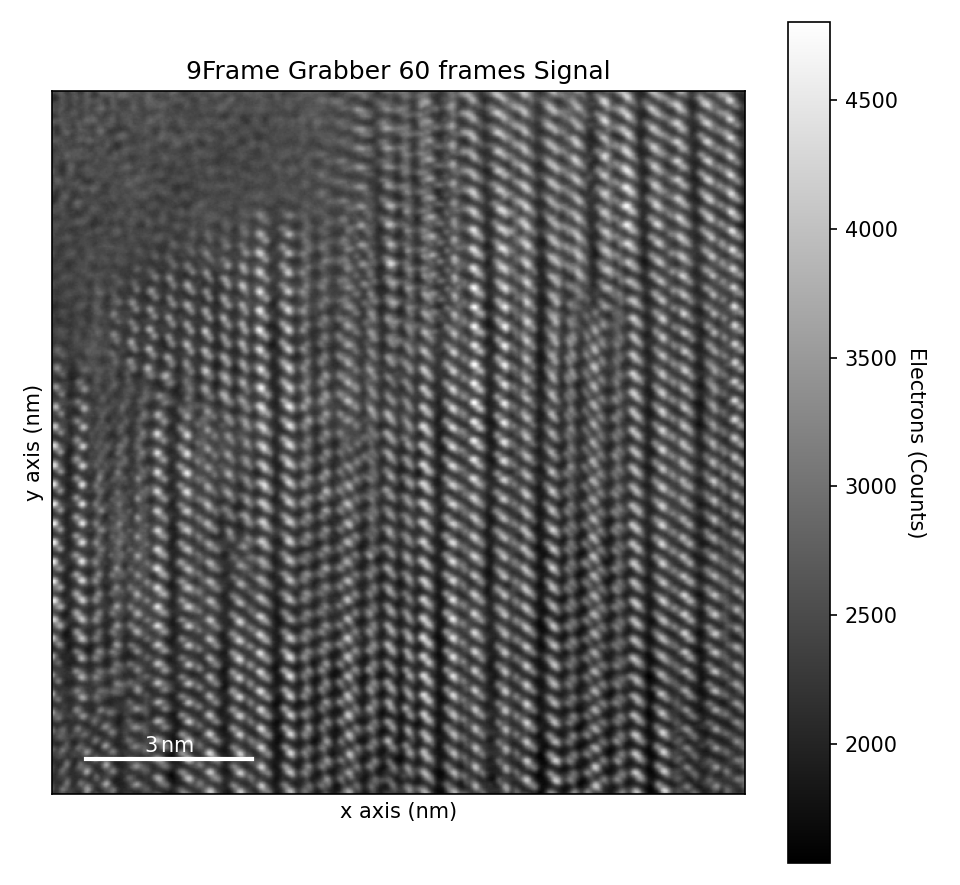

In [9]:
s_temp = s_copy.inav[0].copy()
s_temp = s_copy.sum(0)
s_temp.plot()

<IPython.core.display.Javascript object>


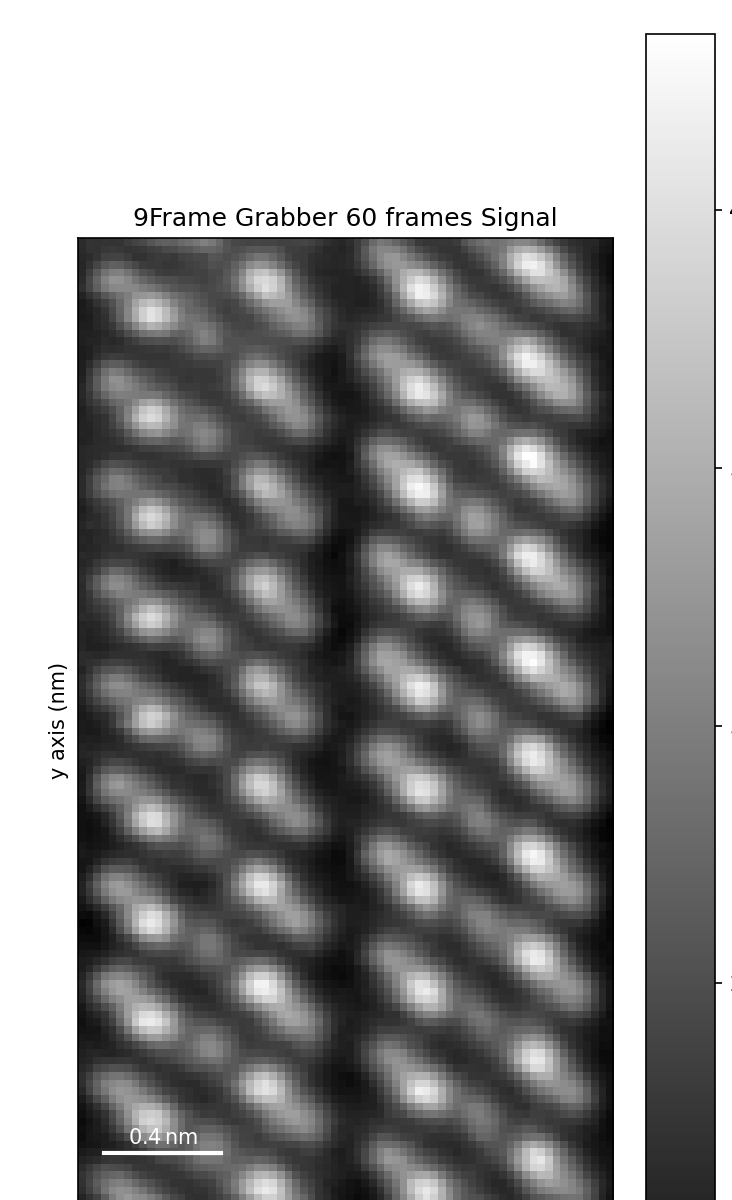

In [10]:
s_temp.isig[85:155,360:499].plot()

In [11]:
s_crop = s_temp.isig[85:155,360:499]

In [12]:
s_peaks = am.get_feature_separation(s_crop, separation_range=(1, 10), show_progressbar=False)

<IPython.core.display.Javascript object>


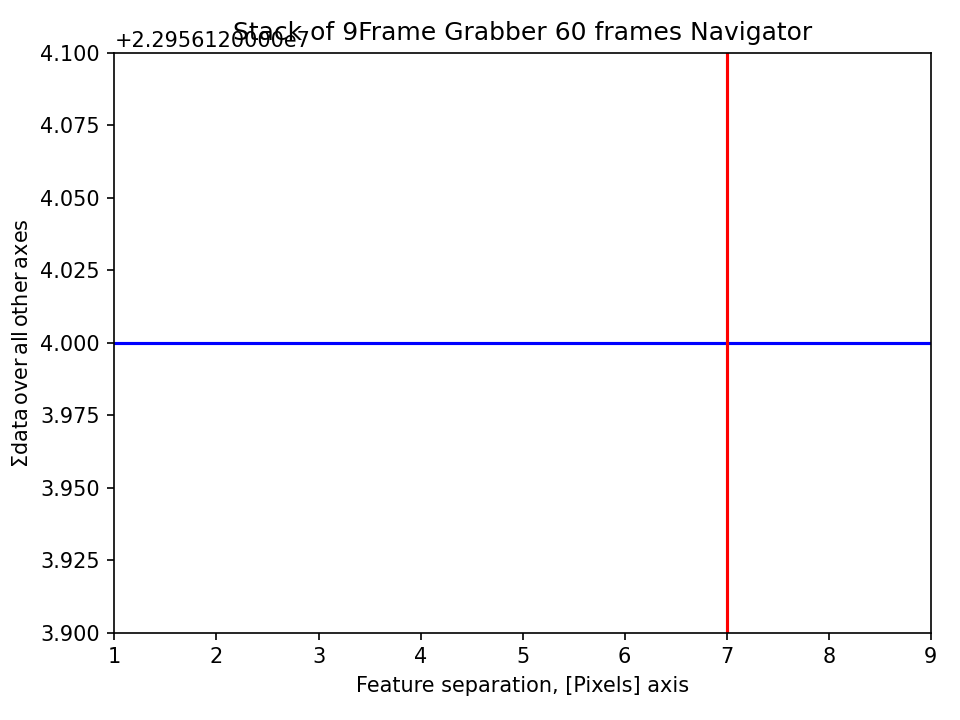

<IPython.core.display.Javascript object>


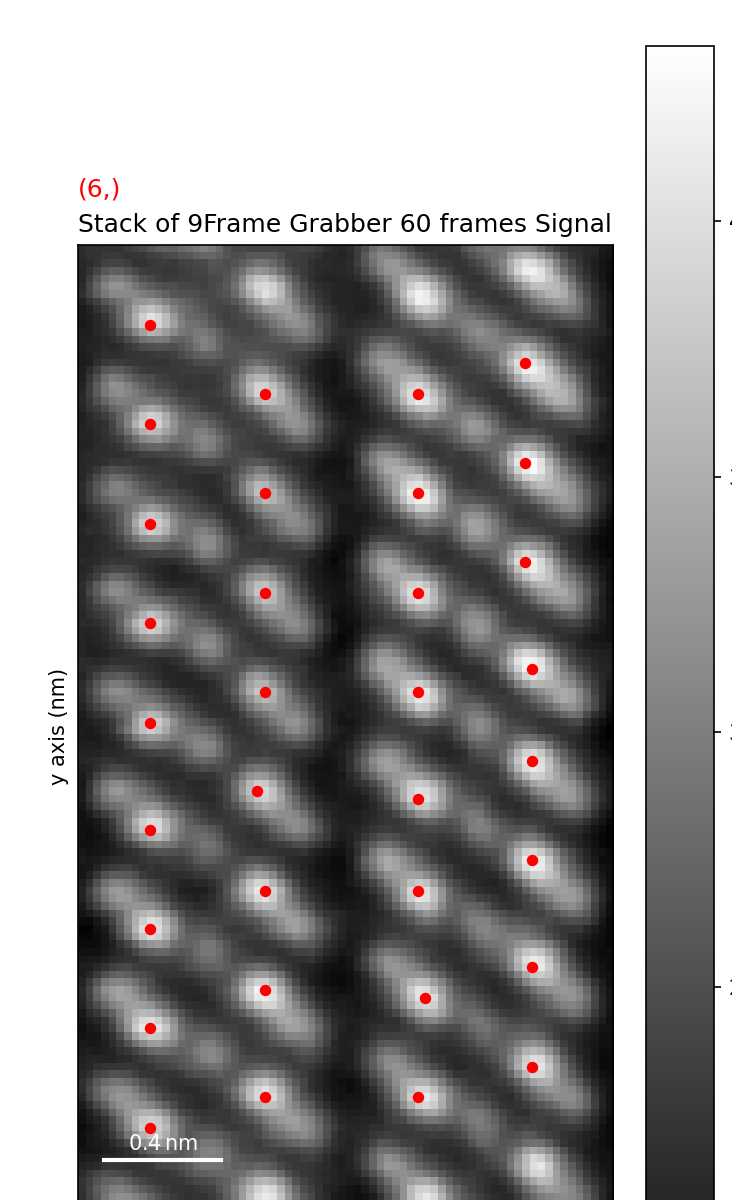

In [13]:
s_peaks.plot()

In [14]:
atom_positions = am.get_atom_positions(s_crop, 7)

<IPython.core.display.Javascript object>


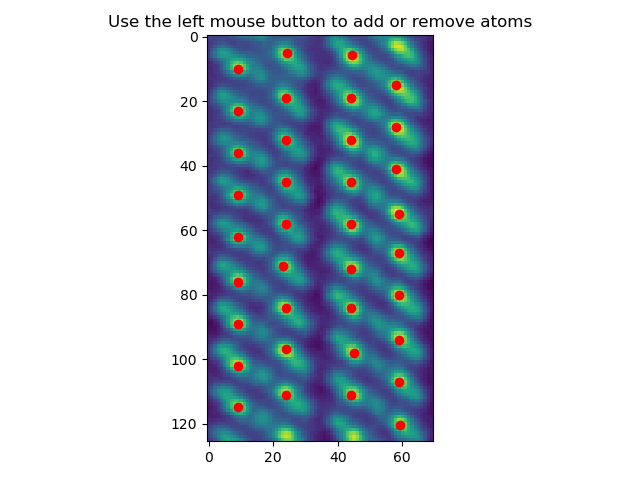

In [38]:
atom_positions_A = am.add_atoms_with_gui(s_crop, atom_positions)

In [41]:
sublattice_In = am.Sublattice(atom_positions_A, image=s_crop.data)
sublattice_In

<Sublattice,  (atoms:36,planes:0)>

In [40]:
s_crop.axes_manager
x_offset = s_crop.axes_manager[0].offset
y_offset = s_crop.axes_manager[1].offset
x_scale = s_crop.axes_manager[0].scale
y_scale = s_crop.axes_manager[1].scale

In [42]:
sublattice_In.find_nearest_neighbors()
sublattice_In.refine_atom_positions_using_center_of_mass(percent_to_nn=0.2)
sublattice_In.refine_atom_positions_using_2d_gaussian(percent_to_nn=0.2)

Center of mass:   0%|          | 0/36 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


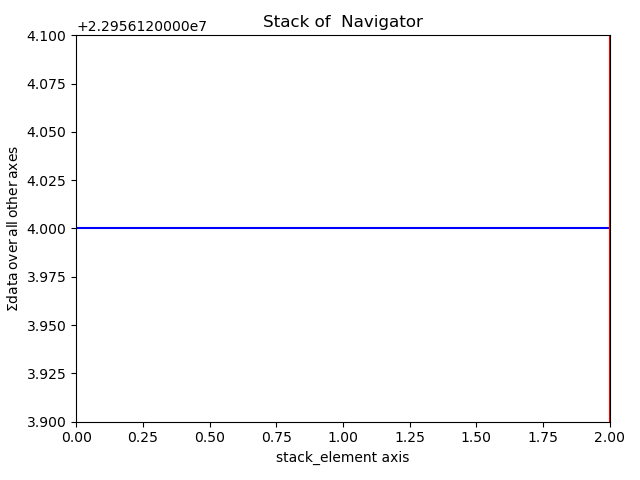

<IPython.core.display.Javascript object>


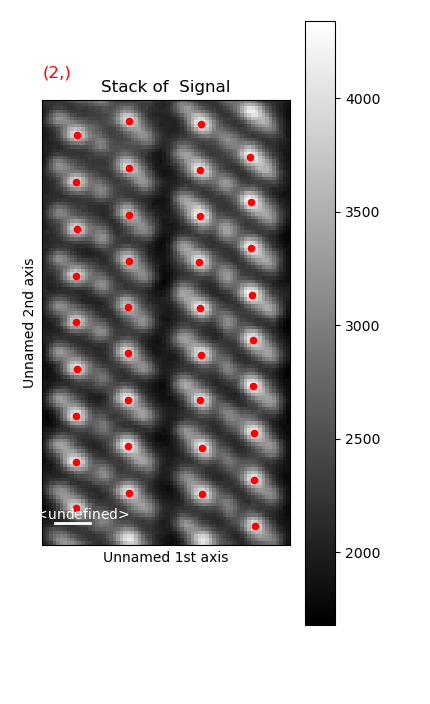

In [43]:
sublattice_In.get_position_history().plot()

In [44]:
sublattice_In.construct_zone_axes(atom_plane_tolerance=2)
sublattice_In

<Sublattice,  (atoms:36,planes:7)>

<IPython.core.display.Javascript object>


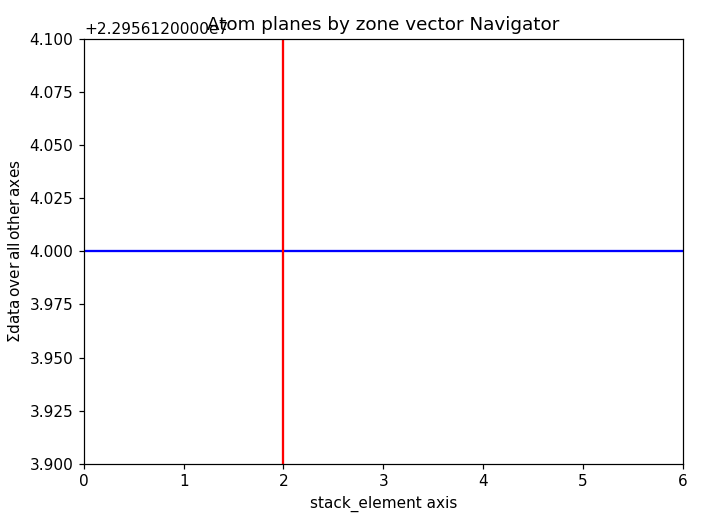

<IPython.core.display.Javascript object>


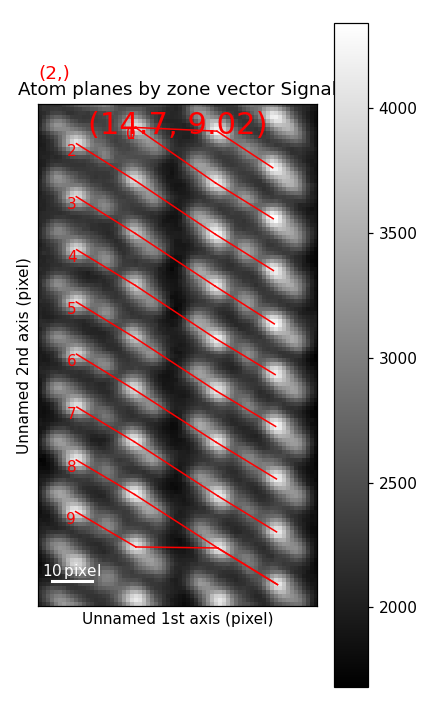

In [45]:
sublattice_In.plot_planes()

In [46]:
zone_axis_001 = sublattice_In.zones_axis_average_distances[2]
B_positions = sublattice_In.find_missing_atoms_from_zone_vector(zone_axis_001)

<IPython.core.display.Javascript object>


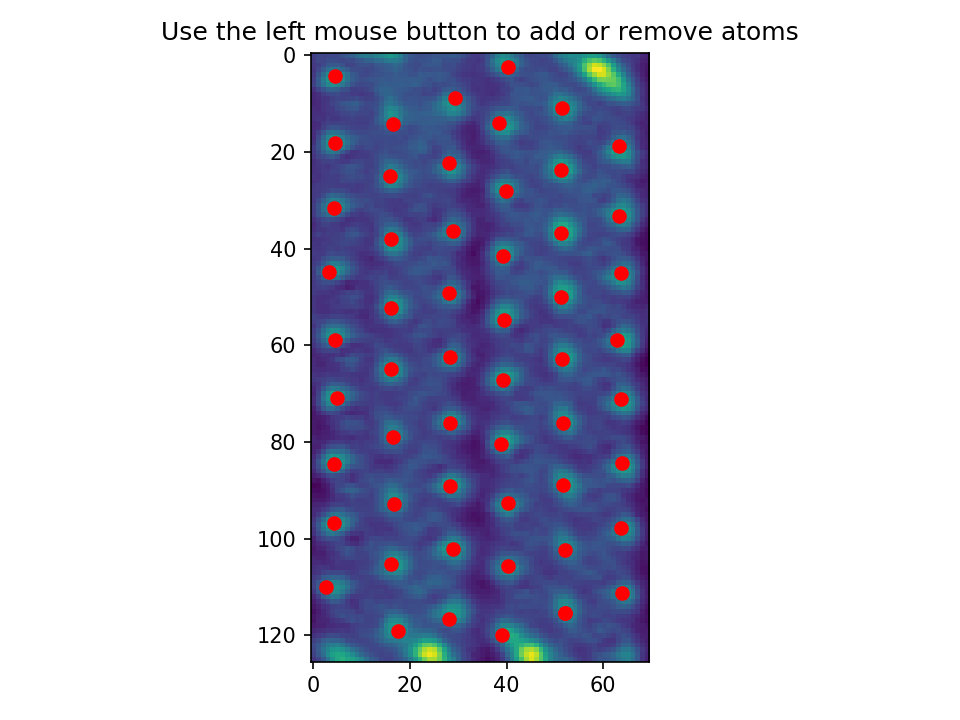

In [64]:
B_positions=am.add_atoms_with_gui(image_without_A, B_positions)

In [57]:
from atomap.tools import remove_atoms_from_image_using_2d_gaussian
image_without_A = remove_atoms_from_image_using_2d_gaussian(sublattice_In.image, sublattice_In)

Subtracting atoms:   0%|          | 0/36 [00:00<?, ?it/s]

In [73]:
#sublattice_B = am.Sublattice(B_positions, image_without_A, color='blue')
sublattice_B.find_nearest_neighbors()
#sublattice_B.construct_zone_axes()
sublattice_B.refine_atom_positions_using_center_of_mass(percent_to_nn=0.2)
sublattice_B.refine_atom_positions_using_2d_gaussian(percent_to_nn=0.2)

Center of mass:   0%|          | 0/55 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


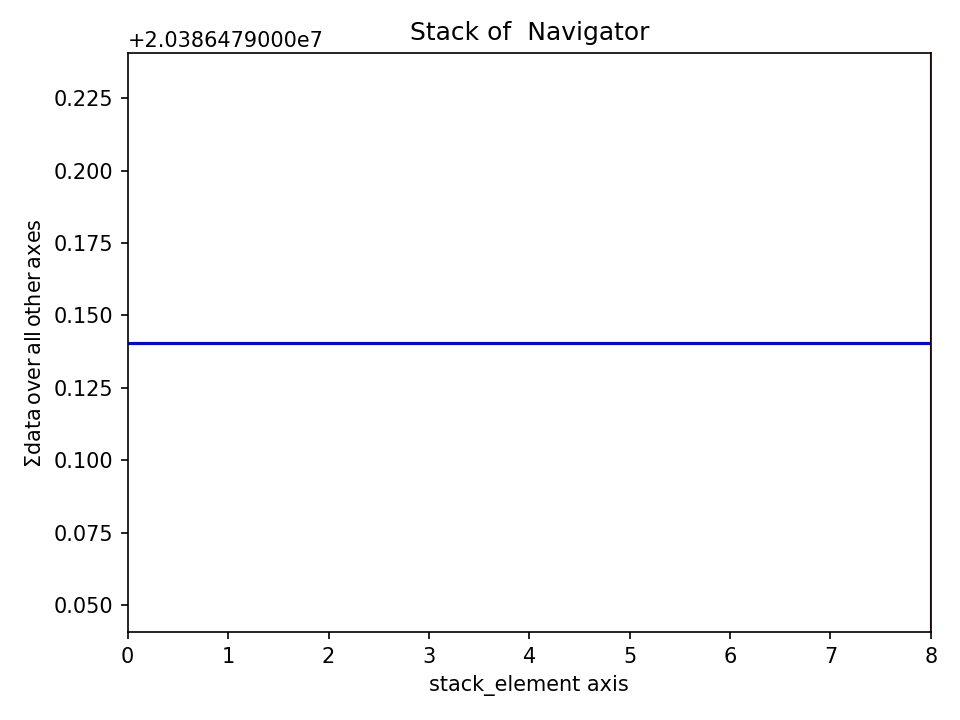

<IPython.core.display.Javascript object>


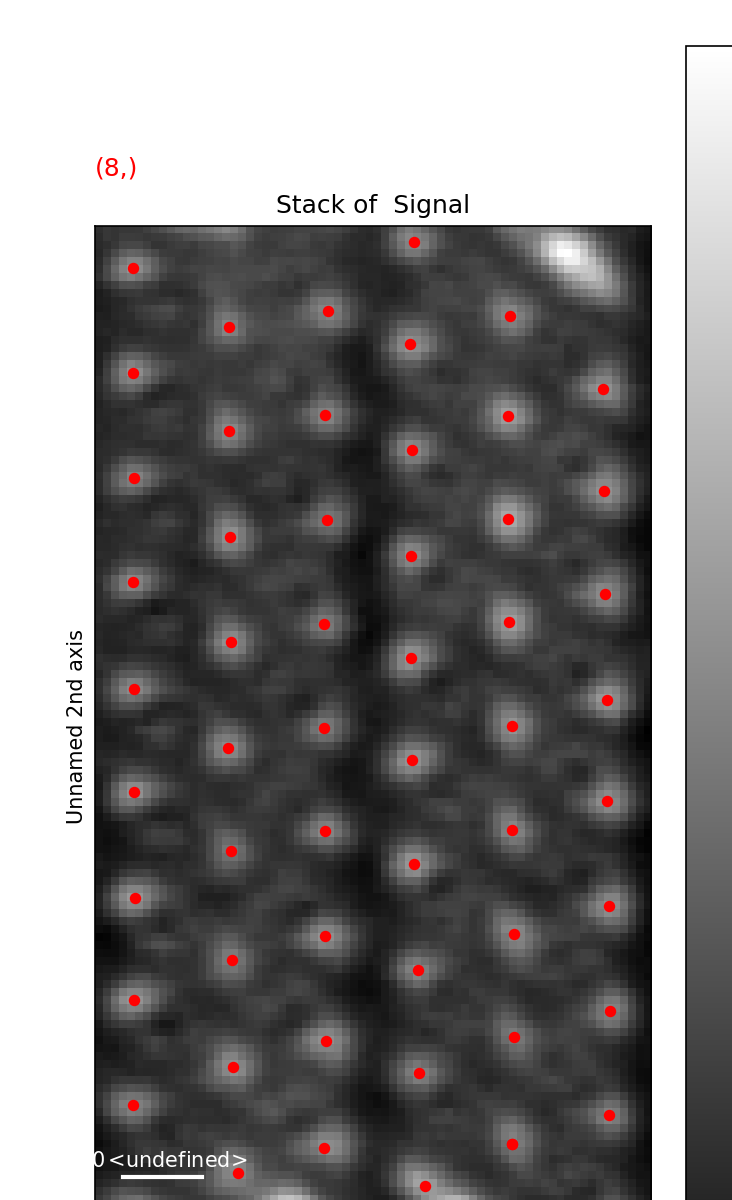

In [74]:
sublattice_B.get_position_history().plot()

<IPython.core.display.Javascript object>


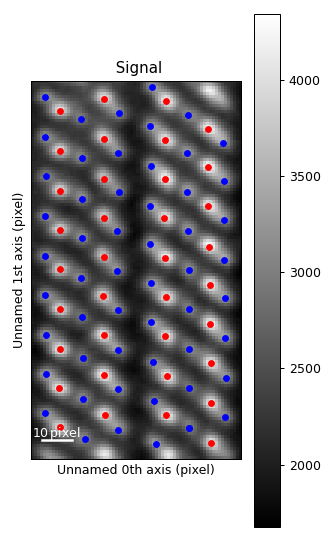

In [98]:
%matplotlib notebook
atom_lattice = am.Atom_Lattice(image=s_crop.data, name='test', sublattice_list=[sublattice_In, sublattice_B])
atom_lattice.plot()

In [76]:
atom_lattice.save("atom_lattice.hdf5", overwrite=True)

In [ ]:
atom_lattice2 = am.load_atom_lattice_from_hdf5("atom_lattice.hdf5")

In [77]:
atom_position_list = sublattice_In.atom_list
atom_position = atom_position_list[0]

In [78]:
sublattice_A = atom_lattice.sublattice_list[0]
x = sublattice_A.x_position
y = sublattice_A.y_position


In [253]:
import numpy as np
blue_columns_x_ranges = [(3, 5), (38, 41), (27,30),(62,65)]
red_columns_x_ranges = [(8, 10), (43, 45),(22,25),(58,60)]
blue_coord = []
red_coord = []


# Function to slice the positions based on x range and calculate distances
def calculate_distances(sublattice_A, sublattice_B, blue_ranges, red_ranges):
    distances = []
    for blue_range, red_range in zip(blue_ranges, red_ranges):
        # Slice the x positions based on the given range
        blue_x = sublattice_B.x_position[(sublattice_B.x_position >= blue_range[0]) & (sublattice_B.x_position <= blue_range[1])]
        red_x = sublattice_A.x_position[(sublattice_A.x_position >= red_range[0]) & (sublattice_A.x_position <= red_range[1])]
        
        # Assuming that the y positions follow the same order as x positions
        blue_y = sublattice_B.y_position[(sublattice_B.x_position >= blue_range[0]) & (sublattice_B.x_position <= blue_range[1])]
        red_y = sublattice_A.y_position[(sublattice_A.x_position >= red_range[0]) & (sublattice_A.x_position <= red_range[1])]
        blue_coord.append((blue_x,blue_y))
        red_coord.append((red_x,red_y))
        # Calculate distances between all pairs of blue and red dots within the sliced range
        for bx, by in zip(blue_x, blue_y):
            for rx, ry in zip(red_x, red_y):
                distance = np.sqrt((bx - rx)**2 + (by - ry)**2)
                distances.append(distance)
    return distances

# Call the function and calculate distances
distances = calculate_distances(sublattice_A, sublattice_B, blue_columns_x_ranges, red_columns_x_ranges)
blue_x_1,blue_y_1 = blue_coord[0][0],blue_coord[0][1]
red_x_1,red_y_1  = red_coord[0][0],red_coord[0][1]
blue_x_2,blue_y_2 = blue_coord[1][0], blue_coord[1][1]
red_x_2,red_y_2  = red_coord[1][0],red_coord[1][1]
blue_x_3,blue_y_3 = blue_coord[2][0],blue_coord[2][1]
red_x_3,red_y_3  = red_coord[2][0],red_coord[2][1]
blue_x_4,blue_y_4 = blue_coord[3][0], blue_coord[3][1]
red_x_4,red_y_4  = red_coord[3][0],red_coord[3][1]

In [102]:
blue_coord

[(array([4.24335568, 4.2973673 , 4.42475827, 4.30503043, 4.32035254,
         4.32094733, 4.46564236, 4.34313459, 4.27354566]),
  array([  4.85555964,  18.06211669,  31.27570318,  44.38667566,
          57.812101  ,  70.74957443,  84.07249834,  96.98532374,
         110.18755741])),
 (array([39.62930414, 39.41145442, 39.26716811, 39.40706424, 40.08515266,
         40.2960162 , 40.96293529, 39.16340515, 39.26411845, 39.6038869 ]),
  array([  1.50821982,  27.73120783,  41.00525676,  66.78120075,
          93.17661428, 106.10075465, 120.33957538,  14.41055203,
          53.92826868,  79.7870868 ])),
 (array([28.31647868, 28.2887832 , 28.45768839, 28.75397069, 28.71633861,
         28.29400286, 28.36327049, 28.42159617, 28.55146553]),
  array([115.61347534,  49.59148674,  23.33997177,  10.20417473,
          36.52957578,  62.72892374,  75.69876378,  88.93427859,
         102.13066215])),
 (array([64.16613356, 63.85151382, 63.35702196, 63.60364301, 63.95312163,
         64.32570332, 64.1448

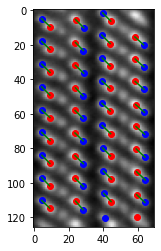

In [257]:
%matplotlib inline
import numpy as np
from math import sqrt

def sort_dots(x, y):
    sorted_indices = np.argsort(y)
    sorted_x = x[sorted_indices]
    sorted_y = y[sorted_indices]
    return sorted_x, sorted_y

def distance(x1, x2, y1, y2):
    return sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def plot_distances(blue_x, blue_y, red_x, red_y, color, x_scale):
    sorted_blue_x, sorted_blue_y = sort_dots(blue_x, blue_y)
    sorted_red_x, sorted_red_y = sort_dots(red_x, red_y)
    distance_list = []
    
    for bx, by, rx, ry in zip(sorted_blue_x, sorted_blue_y, sorted_red_x, sorted_red_y):
        plt.plot([bx, rx], [by, ry], color)
        distance_list.append(distance(bx, rx, by, ry) * x_scale)
    return distance_list

import matplotlib.pyplot as plt

plt.imshow(s_crop.data, cmap='gray')
plt.scatter(blue_x_1,blue_y_1,color='b' )
plt.scatter(red_x_1,red_y_1,color='r' )
plt.scatter(blue_x_2,blue_y_2,color='b' )
plt.scatter(red_x_2,red_y_2,color='r' )
plt.scatter(blue_x_3,blue_y_3,color='b' )
plt.scatter(red_x_3,red_y_3,color='r' )
plt.scatter(blue_x_4,blue_y_4,color='b' )
plt.scatter(red_x_4,red_y_4,color='r' )
distance_list = []
distance_list.extend(plot_distances(blue_x_1, blue_y_1, red_x_1, red_y_1, 'g-', x_scale))
distance_list.extend(plot_distances(blue_x_2, blue_y_2, red_x_2, red_y_2, 'g-', x_scale))
distance_list.extend(plot_distances(blue_x_3, blue_y_3, red_x_3, red_y_3, 'g-', x_scale))
distance_list.extend(plot_distances(blue_x_4, blue_y_4, red_x_4, red_y_4, 'g-', x_scale))
plt.savefig('Figure1.tif')

In [260]:
import pickle

with open("blue_coord.pkl", "wb") as f:
    pickle.dump(blue_coord, f)
    pickle.dump(red_coord, f)

In [261]:
np.savez("blue_coord.npz", *blue_coord)
np.savez("red_coord.npz", *red_coord)

In [275]:
import statistics
distance_list
print('count =',len(distance_list),f'average = {round(statistics.mean(distance_list),3)}nm',
      f'std = {round(statistics.stdev(distance_list),3)}nm')
np.savetxt('1st distance',distance_list)

count = 35 average = 0.175nm std = 0.004nm


<IPython.core.display.Javascript object>


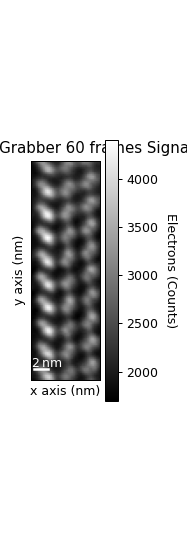

In [125]:
%matplotlib notebook
s_temp.isig[155:195,360:499].plot()

In [126]:
s_crop2 = s_temp.isig[155:195,360:499]

In [127]:
s_peaks2 = am.get_feature_separation(s_crop2, separation_range=(1, 10), show_progressbar=False)

<IPython.core.display.Javascript object>


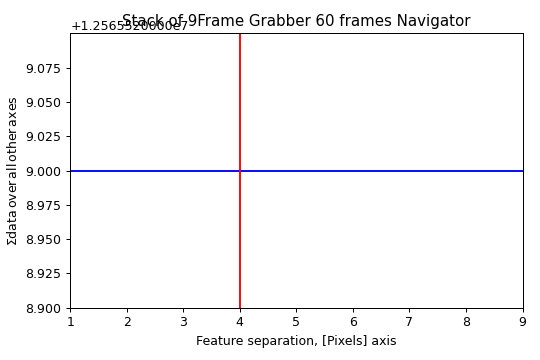

<IPython.core.display.Javascript object>


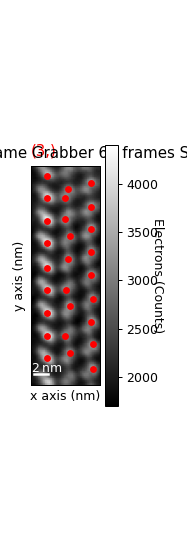

In [128]:
s_peaks2.plot()

<IPython.core.display.Javascript object>


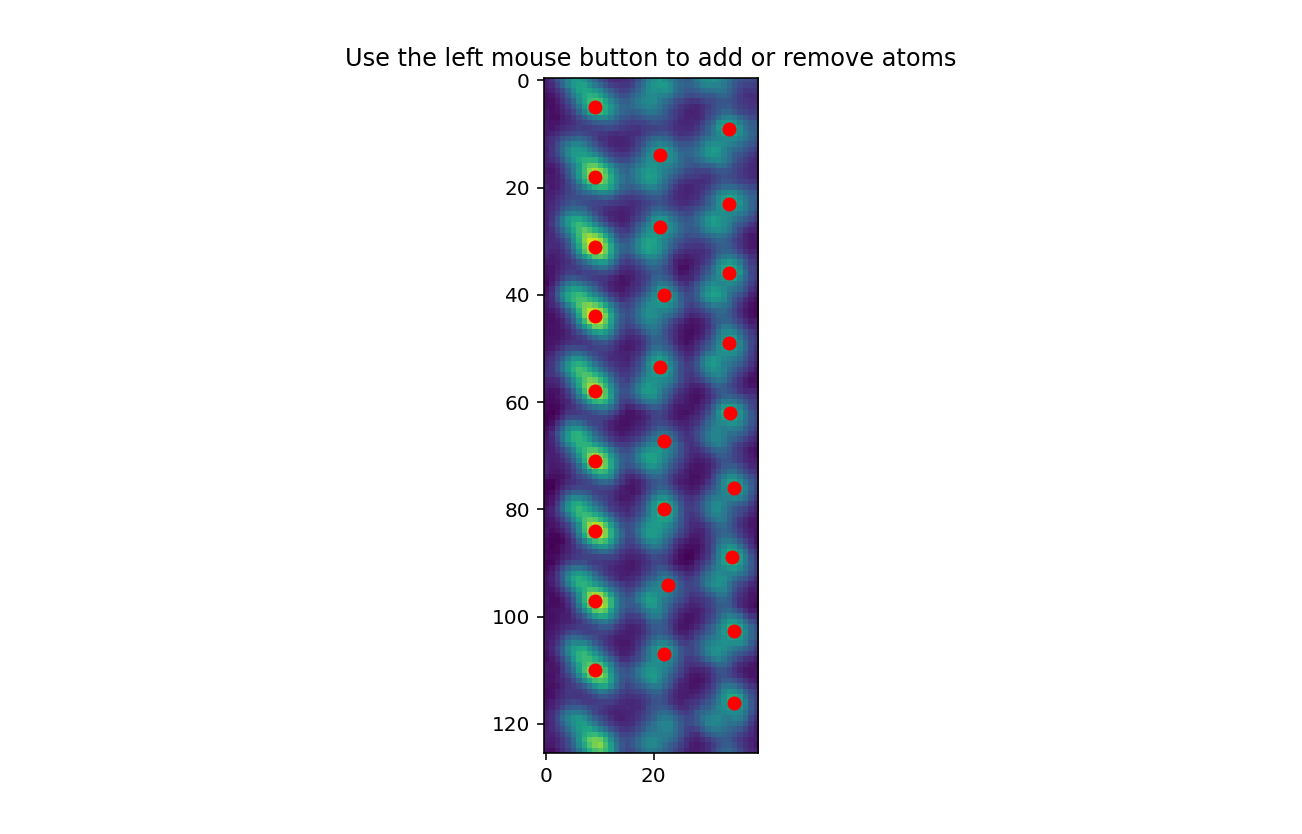

In [217]:
atom_positions2 = am.get_atom_positions(s_crop2, 4)
atom_positions_A2 = am.add_atoms_with_gui(s_crop2, atom_positions2)

In [218]:
sublattice_In2 = am.Sublattice(atom_positions_A2, image=s_crop2.data)

In [219]:

sublattice_In2.find_nearest_neighbors()
sublattice_In2.refine_atom_positions_using_center_of_mass(percent_to_nn=0.1)
sublattice_In2.refine_atom_positions_using_2d_gaussian(percent_to_nn=0.1)

Center of mass:   0%|          | 0/26 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


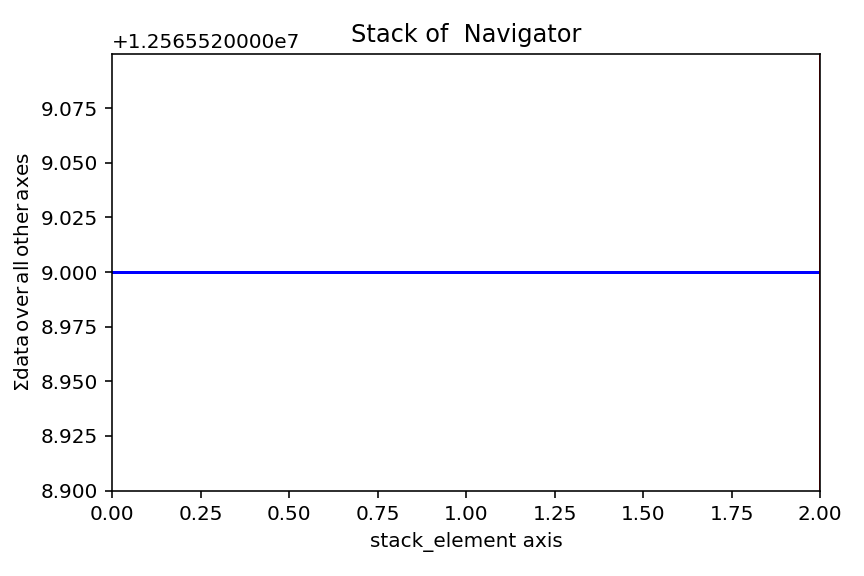

<IPython.core.display.Javascript object>


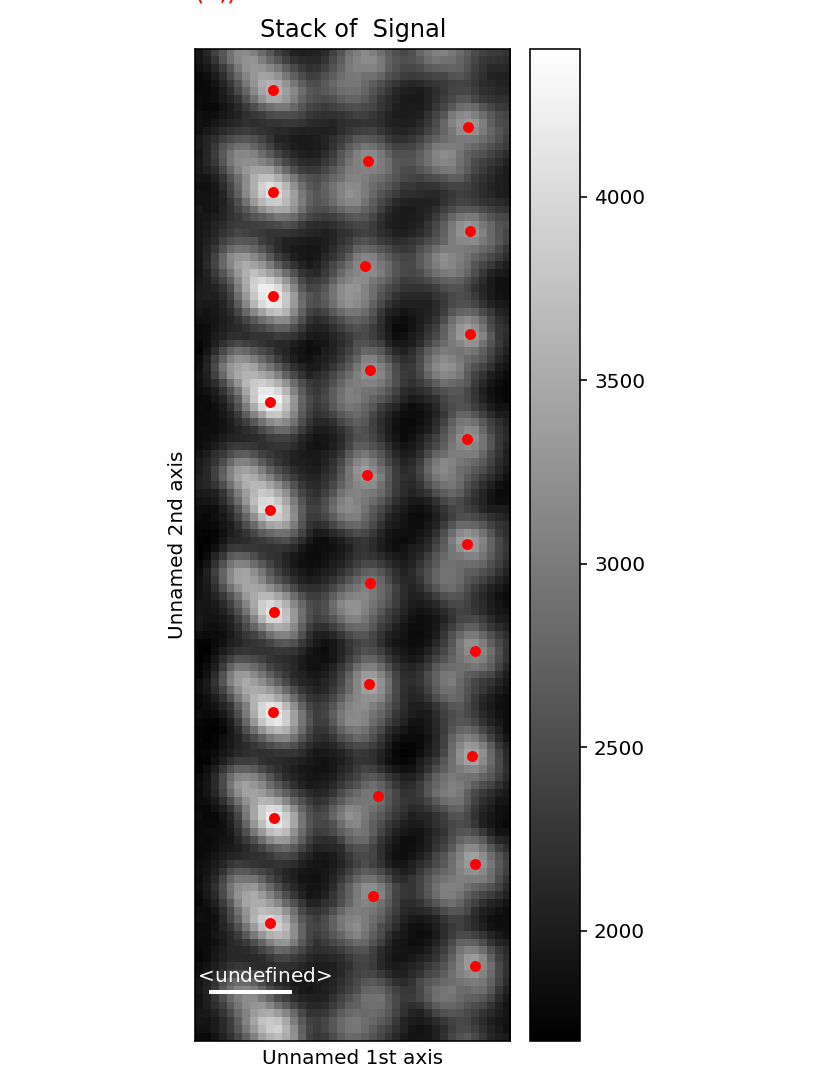

In [220]:
sublattice_In2.get_position_history().plot()

In [221]:
sublattice_In2.construct_zone_axes(atom_plane_tolerance=2)
sublattice_In2

<Sublattice,  (atoms:26,planes:6)>

In [222]:
from atomap.tools import remove_atoms_from_image_using_2d_gaussian
image_without_A2 = remove_atoms_from_image_using_2d_gaussian(sublattice_In2.image, sublattice_In2,percent_to_nn=0.5)

Subtracting atoms:   0%|          | 0/26 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


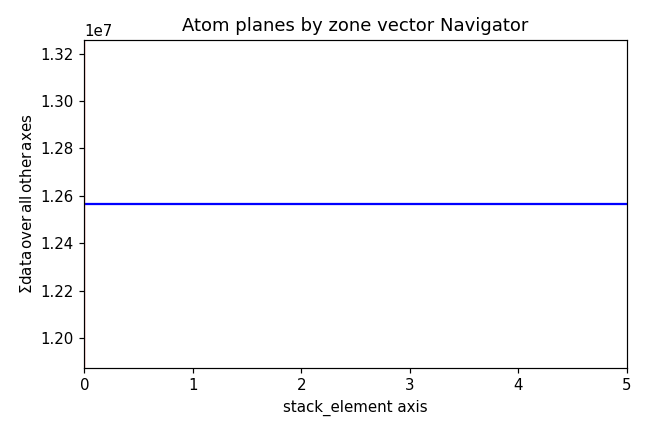

<IPython.core.display.Javascript object>


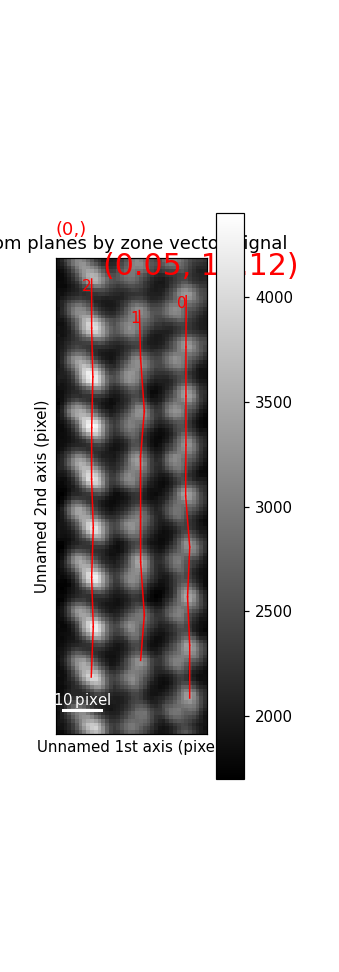

In [167]:
sublattice_In2.plot_planes()

In [223]:
zone_axis_001_2 = sublattice_In2.zones_axis_average_distances[1]
B_positions2 = sublattice_In2.find_missing_atoms_from_zone_vector(zone_axis_001_2)

<IPython.core.display.Javascript object>


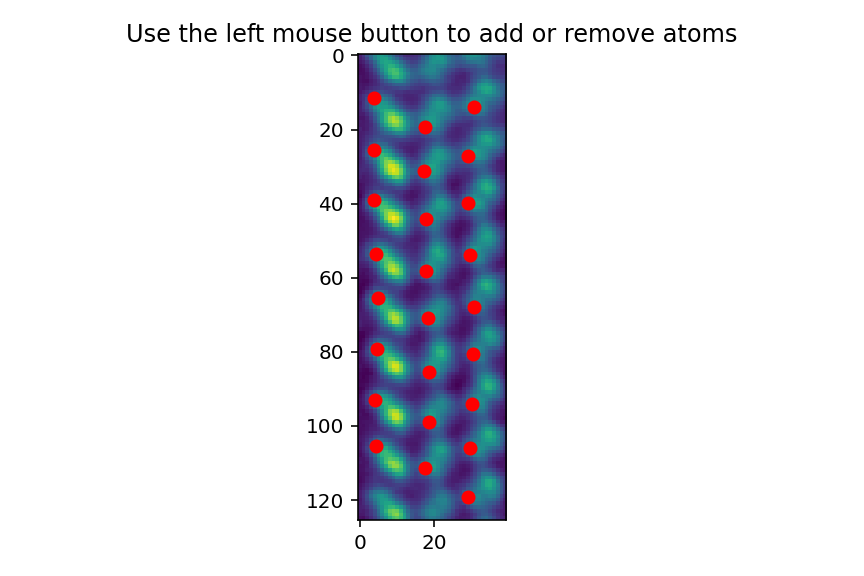

In [234]:
B_positions22=am.add_atoms_with_gui(sublattice_In2.image, B_positions2)

<IPython.core.display.Javascript object>


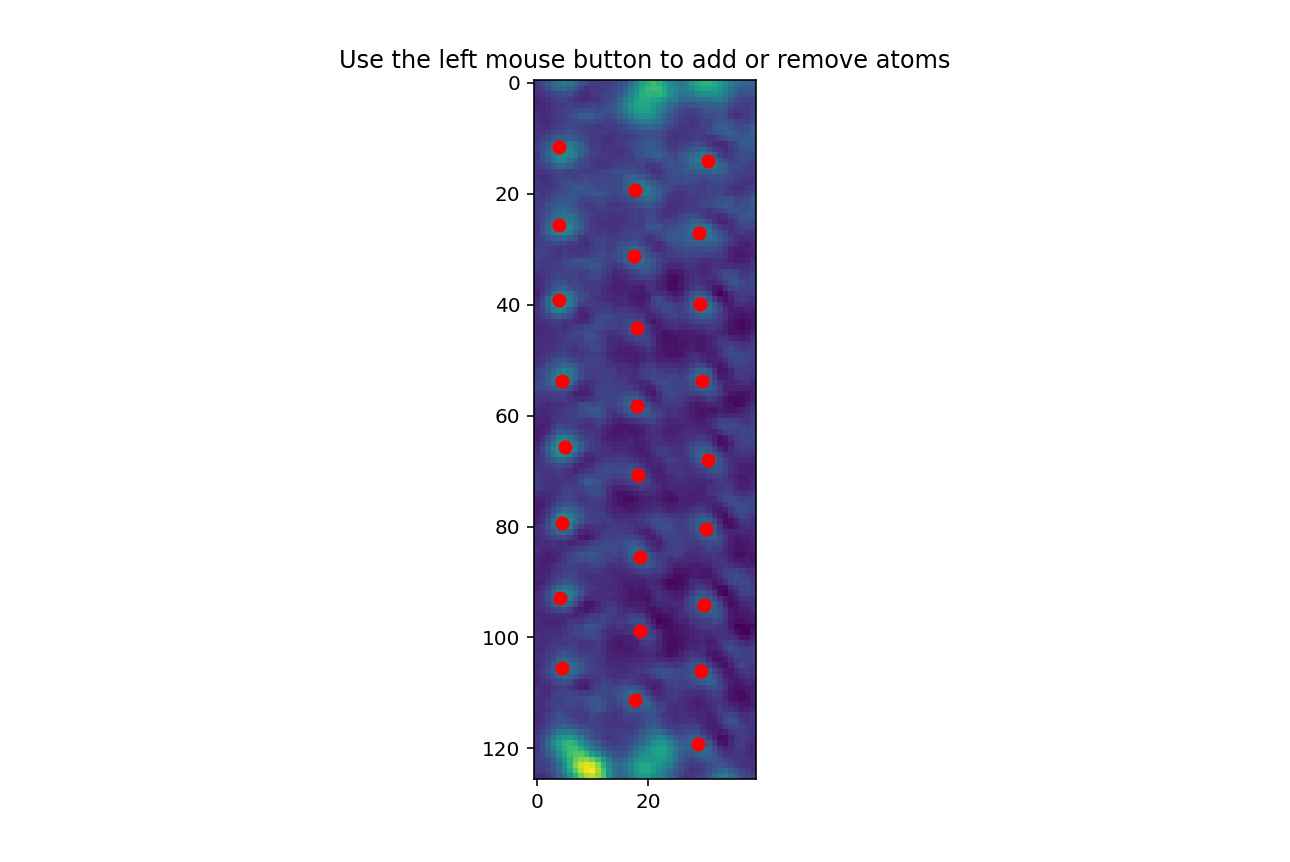

In [235]:
B_positions2=am.add_atoms_with_gui(image_without_A2, B_positions22)

In [247]:
sublattice_B2 = am.Sublattice(B_positions2, sublattice_In2.image, color='blue')
sublattice_B2.find_nearest_neighbors()
#sublattice_B.construct_zone_axes()
sublattice_B2.refine_atom_positions_using_center_of_mass(percent_to_nn=0.2)
sublattice_B2.refine_atom_positions_using_2d_gaussian(percent_to_nn=0.2)

Center of mass:   0%|          | 0/25 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


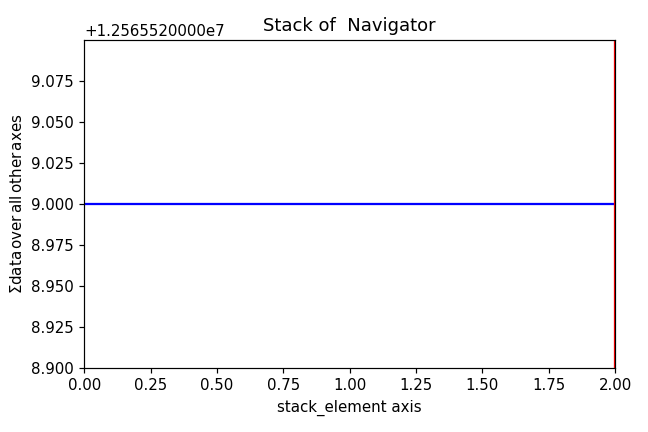

<IPython.core.display.Javascript object>


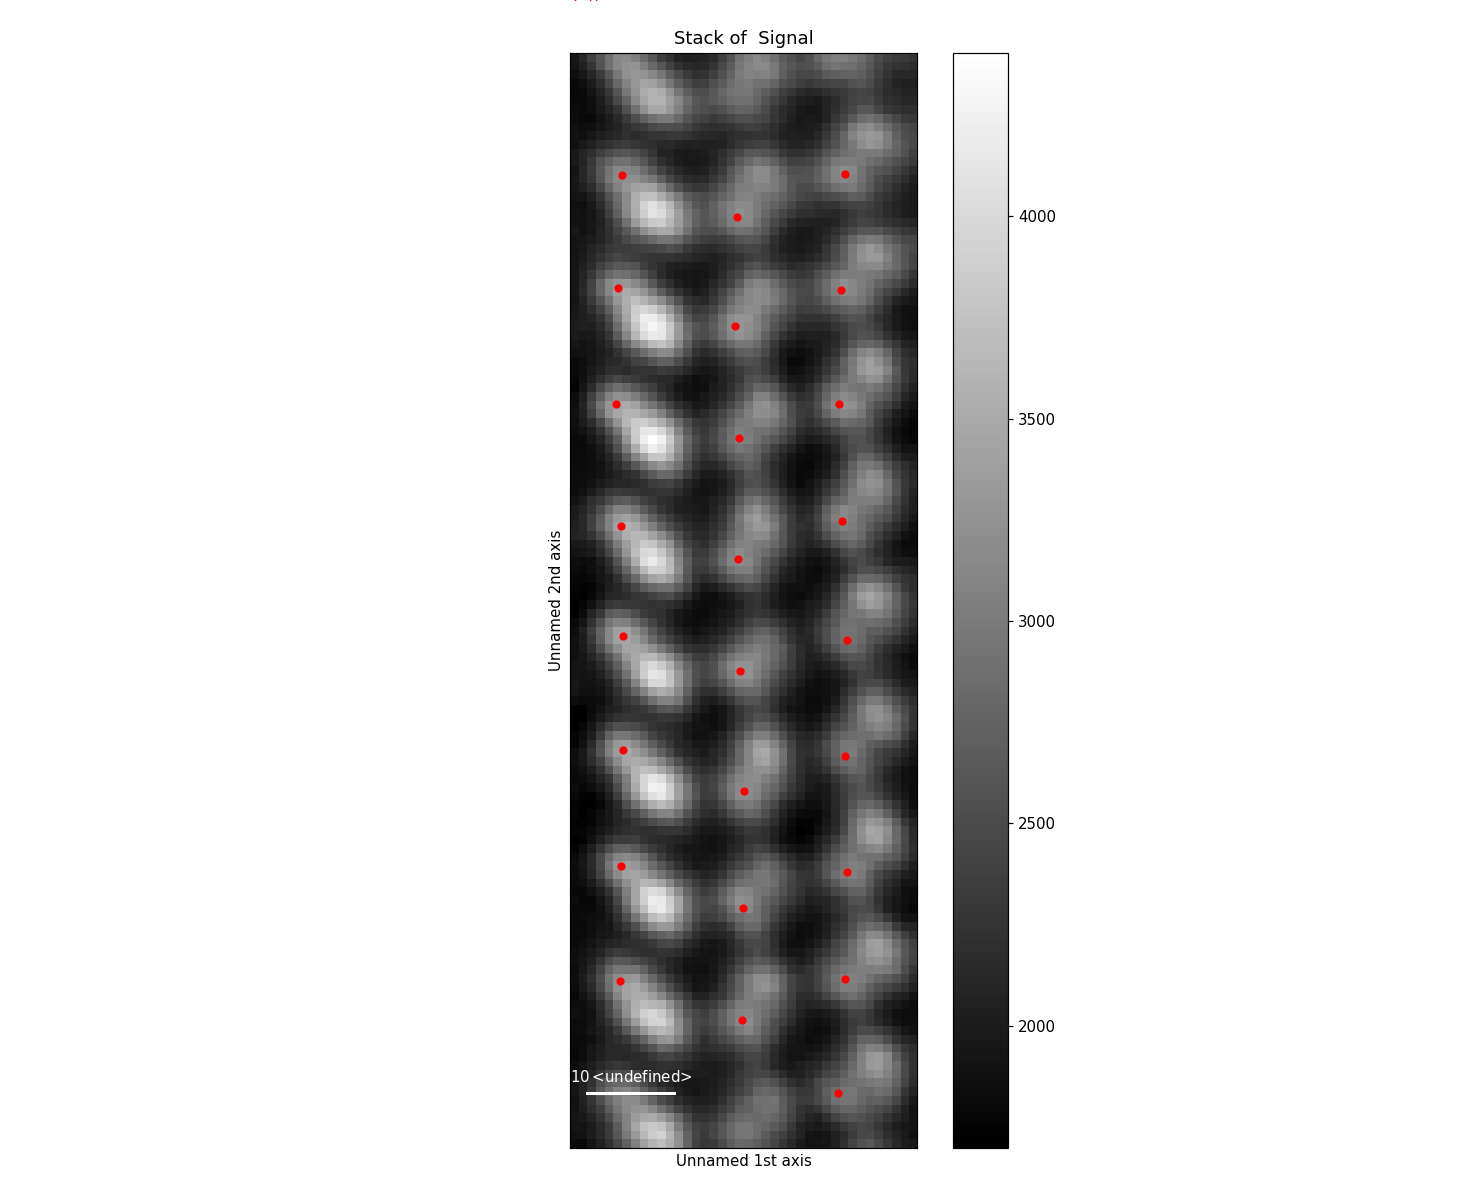

In [248]:
sublattice_B2.get_position_history().plot()

<IPython.core.display.Javascript object>


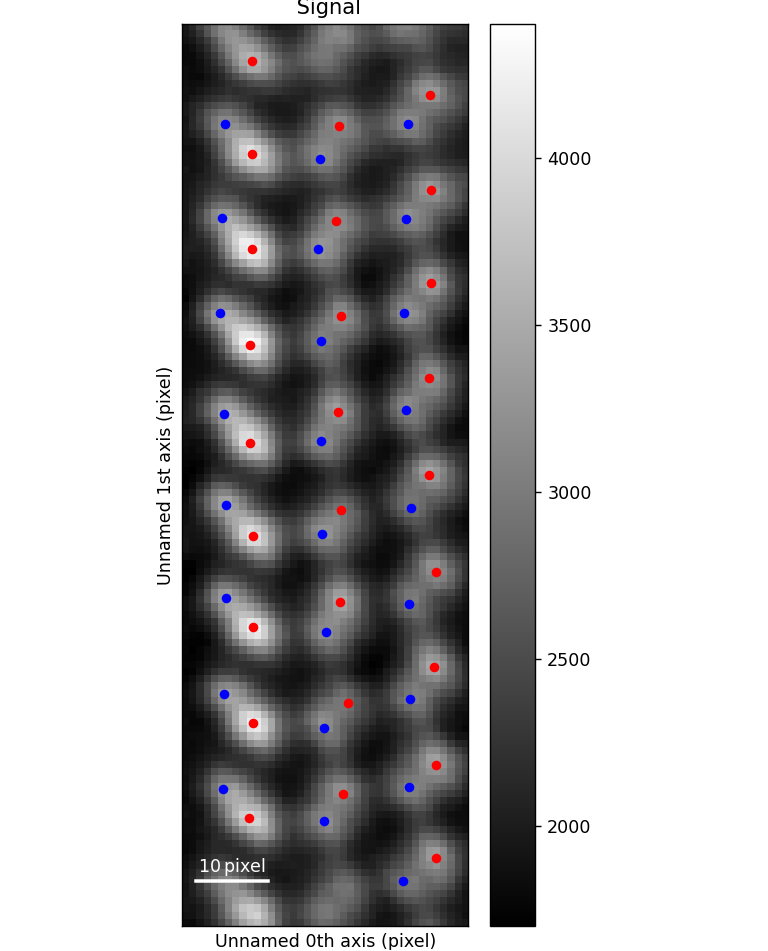

In [277]:
%matplotlib notebook
atom_lattice2 = am.Atom_Lattice(image=s_crop2.data, name='test2', sublattice_list=[sublattice_In2, sublattice_B2])
atom_lattice2.plot()

In [250]:
atom_lattice2.save("atom_lattice-2.hdf5", overwrite=True) 

In [307]:
blue_columns_x_ranges2 = [(4, 6)]
red_columns_x_ranges2 = [(7, 11)]
blue_coord2 = []
red_coord2 = []
# Function to slice the positions based on x range and calculate distances
def calculate_distances(sublattice_A, sublattice_B, blue_ranges, red_ranges):
    distances = []
    for blue_range, red_range in zip(blue_ranges, red_ranges):
        # Slice the x positions based on the given range
        blue_x = sublattice_B.x_position[(sublattice_B.x_position >= blue_range[0]) & (sublattice_B.x_position <= blue_range[1])]
        red_x = sublattice_A.x_position[(sublattice_A.x_position >= red_range[0]) & (sublattice_A.x_position <= red_range[1]) 
                & (sublattice_A.y_position > 5)]
        
        # Assuming that the y positions follow the same order as x positions
        blue_y = sublattice_B.y_position[(sublattice_B.x_position >= blue_range[0]) & (sublattice_B.x_position <= blue_range[1])]
        red_y = sublattice_A.y_position[(sublattice_A.x_position >= red_range[0]) & (sublattice_A.x_position <= red_range[1])
                                       & (sublattice_A.y_position > 5)]
        blue_coord2.append((blue_x,blue_y))
        red_coord2.append((red_x,red_y))
        # Calculate distances between all pairs of blue and red dots within the sliced range
        for bx, by in zip(blue_x, blue_y):
            for rx, ry in zip(red_x, red_y):
                distance = np.sqrt((bx - rx)**2 + (by - ry)**2)
                distances.append(distance)
    return distances


# Call the function and calculate distances
distances2 = calculate_distances(sublattice_In2, sublattice_B2, blue_columns_x_ranges2, red_columns_x_ranges2)
blue2_x_1,blue2_y_1 = blue_coord2[0][0],blue_coord2[0][1]
red2_x_1,red2_y_1  = red_coord2[0][0],red_coord2[0][1]

In [270]:
red_coord2

[(array([9.0272412 , 9.32857817, 9.35936721, 9.44132083, 8.99769217,
         9.44996562, 9.3211557 , 8.9063831 ]),
  array([ 44.35997312,  30.9232071 ,  83.70237729,  97.13614337,
          57.99432233,  70.9355078 ,  17.66482649, 110.44311356]))]

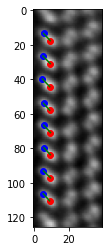

In [308]:
%matplotlib inline


plt.imshow(s_crop2.data, cmap='gray')
plt.scatter(blue2_x_1,blue2_y_1,color='b' )
plt.scatter(red2_x_1,red2_y_1,color='r' )
distance_list2 = []
distance_list2.extend(plot_distances(blue2_x_1, blue2_y_1, red2_x_1, red2_y_1, 'g-', x_scale))
plt.savefig('Figure2.tif')

In [272]:
import pickle

with open("blue_coord2.pkl", "wb") as f:
    pickle.dump(blue_coord2, f)
with open("red_coord2.pkl", "wb") as f:
    pickle.dump(red_coord2, f)

In [273]:
np.savez("blue_coord2.npz", *blue_coord2)
np.savez("red_coord2.npz", *red_coord2)

In [276]:
print('count =',len(distance_list2),f'average = {round(statistics.mean(distance_list2),3)}nm',
      f'std = {round(statistics.stdev(distance_list2),3)}nm')
np.savetxt('2nd distance',distance_list2)

count = 8 average = 0.151nm std = 0.008nm


In [287]:
blue_columns_x_ranges3 = (16,20),(29,32)
red_columns_x_ranges3 = (20,23),(33,36)
blue_coord3 = []
red_coord3 = []
# Function to slice the positions based on x range and calculate distances
def calculate_distances(sublattice_A, sublattice_B, blue_ranges, red_ranges):
    distances = []
    for blue_range, red_range in zip(blue_ranges, red_ranges):
        # Slice the x positions based on the given range
        blue_x = sublattice_B.x_position[(sublattice_B.x_position >= blue_range[0]) & (sublattice_B.x_position <= blue_range[1])]
        red_x = sublattice_A.x_position[(sublattice_A.x_position >= red_range[0]) & (sublattice_A.x_position <= red_range[1]) 
                & (sublattice_A.y_position > 5)]
        
        # Assuming that the y positions follow the same order as x positions
        blue_y = sublattice_B.y_position[(sublattice_B.x_position >= blue_range[0]) & (sublattice_B.x_position <= blue_range[1])]
        red_y = sublattice_A.y_position[(sublattice_A.x_position >= red_range[0]) & (sublattice_A.x_position <= red_range[1])
                                       & (sublattice_A.y_position > 5)]
        blue_coord3.append((blue_x,blue_y))
        red_coord3.append((red_x,red_y))
        # Calculate distances between all pairs of blue and red dots within the sliced range
        for bx, by in zip(blue_x, blue_y):
            for rx, ry in zip(red_x, red_y):
                distance = np.sqrt((bx - rx)**2 + (by - ry)**2)
                distances.append(distance)
    return distances


# Call the function and calculate distances
distances3 = calculate_distances(sublattice_In2, sublattice_B2, blue_columns_x_ranges3, red_columns_x_ranges3)
blue3_x_1,blue3_y_1 = blue_coord3[0][0],blue_coord3[0][1]
red3_x_1,red3_y_1  = red_coord3[0][0],red_coord3[0][1]
blue3_x_2,blue3_y_2 = blue_coord3[1][0],blue_coord3[1][1]
red3_x_2,red3_y_2  = red_coord3[1][0],red_coord3[1][1]

In [288]:
red_coord3

[(array([21.55178226, 21.9932805 , 21.66864311, 21.00139377, 21.31268049,
         21.67811719, 22.6448714 , 21.35308818]),
  array([ 80.15983256, 106.9896186 ,  40.32249569,  27.00505111,
          53.64850627,  67.34925665,  94.3285785 ,  13.67685634])),
 (array([34.29718933, 34.98881159, 34.06666057, 34.31850223, 34.0021733 ,
         34.99546929, 33.92041133, 34.6570071 , 34.99506421]),
  array([ 35.64054172, 115.99447615,   9.40747794,  22.64526152,
          49.00036496,  75.99375807,  62.4212138 ,  89.33047706,
         102.99086695]))]

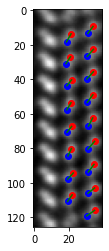

In [290]:
%matplotlib inline


plt.imshow(s_crop2.data, cmap='gray')
plt.scatter(blue3_x_1,blue3_y_1,color='b' )
plt.scatter(red3_x_1,red3_y_1,color='r' )
plt.scatter(blue3_x_2,blue3_y_2,color='b' )
plt.scatter(red3_x_2,red3_y_2,color='r' )
distance_list3 = []
distance_list3.extend(plot_distances(blue3_x_1, blue3_y_1, red3_x_1, red3_y_1, 'g-', x_scale))
distance_list3.extend(plot_distances(blue3_x_2, blue3_y_2, red3_x_2, red3_y_2, 'g-', x_scale))
plt.savefig('Figure3.tif')

In [291]:
import pickle

with open("blue_coord3.pkl", "wb") as f:
    pickle.dump(blue_coord2, f)
with open("red_coord3.pkl", "wb") as f:
    pickle.dump(red_coord2, f)
np.savez("blue_coord3.npz", *blue_coord3)
np.savez("red_coord3.npz", *red_coord3)

In [296]:
print('count =',len(distance_list3[:8]),f'average = {round(statistics.mean(distance_list3[:8]),3)}nm',
      f'std = {round(statistics.stdev(distance_list3[:8]),3)}nm')
print('count =',len(distance_list3[8:]),f'average = {round(statistics.mean(distance_list3[8:]),3)}nm',
      f'std = {round(statistics.stdev(distance_list3[8:]),3)}nm')
np.savetxt('3rd distance',distance_list3)

count = 8 average = 0.123nm std = 0.009nm
count = 9 average = 0.142nm std = 0.008nm


In [297]:
s_whole=s_temp.isig[85:195,360:499]

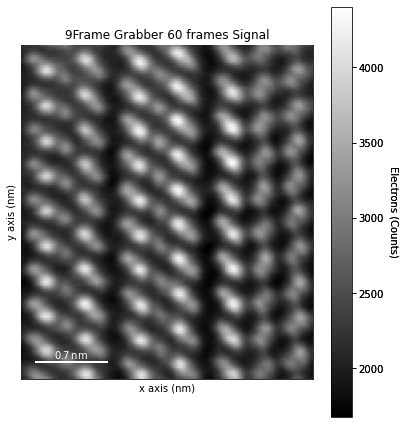

In [298]:
s_whole.plot()

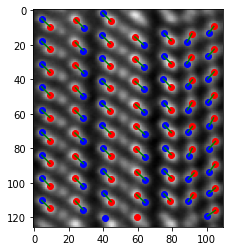

In [315]:
plt.imshow(s_whole.data, cmap='gray')
plt.scatter(blue_x_1,blue_y_1,color='b' )
plt.scatter(red_x_1,red_y_1,color='r' )
plt.scatter(blue_x_2,blue_y_2,color='b' )
plt.scatter(red_x_2,red_y_2,color='r' )
plt.scatter(blue_x_3,blue_y_3,color='b' )
plt.scatter(red_x_3,red_y_3,color='r' )
plt.scatter(blue_x_4,blue_y_4,color='b' )
plt.scatter(red_x_4,red_y_4,color='r' )
distance_list = []
plot_distances(blue_x_1, blue_y_1, red_x_1, red_y_1, 'g-', x_scale)
plot_distances(blue_x_2, blue_y_2, red_x_2, red_y_2, 'g-', x_scale)
plot_distances(blue_x_3, blue_y_3, red_x_3, red_y_3, 'g-', x_scale)
plot_distances(blue_x_4, blue_y_4, red_x_4, red_y_4, 'g-', x_scale)

shifted =155-85

plt.scatter(blue2_x_1+shifted,blue2_y_1,color='b' )
plt.scatter(red2_x_1+shifted,red2_y_1,color='r' )
plot_distances(blue2_x_1+shifted, blue2_y_1, red2_x_1+shifted, red2_y_1, 'g-', x_scale)

plt.scatter(blue3_x_1+shifted,blue3_y_1,color='b' )
plt.scatter(red3_x_1+shifted,red3_y_1,color='r' )
plt.scatter(blue3_x_2+shifted,blue3_y_2,color='b' )
plt.scatter(red3_x_2+shifted,red3_y_2,color='r' )
plot_distances(blue3_x_1+shifted, blue3_y_1, red3_x_1+shifted, red3_y_1, 'g-', x_scale)
plot_distances(blue3_x_2+shifted, blue3_y_2, red3_x_2+shifted, red3_y_2, 'g-', x_scale)
plt.savefig('Figure_whole.tif')

In [304]:
blue2_x_1+1

array([6.43952122, 6.06901325, 5.78387546, 6.41097788, 6.57960258,
       6.23815582, 6.63280127, 6.36313322])